# Analisis de undersampling Tarea 1

#### Estudiantes:
- Nicolás Prieto Escobar
- Pablo A. Saldarriaga Aristizabal

### Problema:

Se cuenta con información georeferenciada de accidentes que han ocurrido en diferentes barrios en la ciudad de Medellín durante el año 2017, se tienen alrededor de 312 barrios diferentes en el conjunto de datos. El objetivo para este caso de estudio, es hora a hora tratar de predecir si en un barrio determinado ocurrirá o no un accidente en base a las condiciones climáticas actuales.

### Importación de paquetes para ejecutar este Notebook

In [1]:
%matplotlib notebook

In [2]:
### Silencio warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import random
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

C:\Users\nicol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\nicol\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nicol\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nicol\Anaconda3\lib\site-packages\tensorflow\python\framework\

In [3]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

Fijamos la semilla aleatoria para garantizar replicabilidad

In [5]:
SEED = 1  # use this constant seed everywhere
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)  # `python` built-in pseudo-random generator
np.random.seed(SEED)  # numpy pseudo-random generator

#### Datos para la tarea
Para utilizar técnicas de ingeniería de características, en esta tarea consideramos la información del barrio "La Candelaria" en el periodo de tiempo Junio 1 a Diciembre 31 de 2017. Las variables climáticas disponibles en el conjunto de datos son:

- icon
- precipIntensity
- precipProbability
- temperature
- apparentTemperature
- dewPoint
- humidity
- windSpeed
- cloudCover
- uvIndex
- visibility

In [8]:
### Lectura del dataset a usar (se usa un subconjunto del dataset por motivos de tiempo)
data = pd.read_csv('../data/data_tarea1.csv',sep =',')
data['TW'] = pd.to_datetime(data['TW'])

Agregamos variables relacionadas a la fecha, como lo son la hora en la que occure el accidente y el día de la semana

In [9]:
### Agregar otras features
data['hora'] = data['TW'].dt.hour
data['dia_sem'] = data['TW'].dt.dayofweek

data= pd.get_dummies(data, columns=['hora'])
data= pd.get_dummies(data, columns=['icon'])
data= pd.get_dummies(data, columns=['dia_sem'])

Adicional a las variables que se crearon, realizaremos un aumento del conjunto de datos en base a uno de los estadisticos que da información distribucional de las variables, la cual es la media. Las variables climaticas que estamos considerando, son series de tiempo para las cuales, se les verificó previamente su estacionariedad, así que a forma de obtener una mayor información de cada una de la series, agregamos para cada una, una media móvil de las últimas 5 horas

In [10]:
freq = '5H'
variables = ['temperature','precipIntensity','apparentTemperature','dewPoint','humidity','windSpeed','cloudCover','visibility']

In [11]:
data_aux = data.copy()
data_aux.index = data_aux.TW
data_aux = data_aux.sort_index()
data_aux = data_aux.drop(columns = 'TW')
resample_data = data_aux[variables].rolling(freq, closed = 'left').mean()

In [12]:
data_pivot = data_aux.pivot_table(values=variables, index='TW',columns='BARRIO', aggfunc=sum)
data_mean = data_pivot.rolling(freq, closed = 'left').mean().stack().reset_index(drop = False)

col_means = [*data_mean.columns[:2]]
for col in data_mean.columns[2:]:
    col_means.append(col + '_mean')
    
data_mean.columns = col_means

In [13]:
data = data.merge(data_mean, how = 'left', on = ['TW','BARRIO'])
data = data.dropna().reset_index(drop = True)

In [14]:
### Seleccionar variable entrada y salida 
X = data.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y = data['Accidente'].reset_index(drop=True)               # target feature
X = X[X.columns[2:]]

In [15]:
X.columns

Index(['precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'hora_0', 'hora_1', 'hora_2',
       'hora_3', 'hora_4', 'hora_5', 'hora_6', 'hora_7', 'hora_8', 'hora_9',
       'hora_10', 'hora_11', 'hora_12', 'hora_13', 'hora_14', 'hora_15',
       'hora_16', 'hora_17', 'hora_18', 'hora_19', 'hora_20', 'hora_21',
       'hora_22', 'hora_23', 'icon_clear-day', 'icon_clear-night',
       'icon_cloudy', 'icon_fog', 'icon_partly-cloudy-day',
       'icon_partly-cloudy-night', 'icon_rain', 'dia_sem_0', 'dia_sem_1',
       'dia_sem_2', 'dia_sem_3', 'dia_sem_4', 'dia_sem_5', 'dia_sem_6',
       'apparentTemperature_mean', 'cloudCover_mean', 'dewPoint_mean',
       'humidity_mean', 'precipIntensity_mean', 'temperature_mean',
       'visibility_mean', 'windSpeed_mean'],
      dtype='object')

In [16]:
X.shape

(5112, 56)

In [82]:
y.sum()

529.0

Se realiza la partición del conjunto de datos en 3 conjuntos:
- Train (60%)
- Validation (20%)
- Test (20%)

In [30]:
### Partir en train y test los datos
X_train, X_val1, y_train, y_val1 = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.40,  random_state = 42)

In [31]:
X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1,
                                                    stratify=y_val1, 
                                                    test_size=0.5,  random_state = 42)

In [32]:
X_train.shape

(3067, 56)

In [33]:
X_test.shape

(1023, 56)

In [34]:
y_test.sum()

106.0

In [35]:
X_val.shape

(1022, 56)

In [24]:
y_val.sum()

106.0

In [70]:
### Este es el modelo que sera explotado por los metodos de envoltura y el que usaremos en este notebook
clf = ExtraTreesClassifier(n_estimators=70, random_state = 42)

Evaluamos el rendimiento del modelo en validacion usando todos los datos (sin undersampling).

In [71]:
### Rendimiento con datos completos
clf.fit(X_train, y_train)
predu = clf.predict_proba(X_val)
auc = roc_auc_score(y_val, predu[:,1]) 
print('ROC AUC Score al usar todos los datos: ')
print(auc)

ROC AUC Score al usar todos los datos: 
0.6301701408914888


### Analisis de sensibilidad del undersampling

Debido a que los datos se encuentran muy desbalanceados, realizamos un undersampling de forma tal que obtengamos una proporcion mas balanceada entre la cantidad de 1's y 0's.
Vamos a comparar aqui distintas proporciones deseadas para hacer el undersampling para ver con cual se obtienen mejores resultados.


In [91]:
rendims = []
props = []

    
### Le agregamos el rendimiento original para que quede mas completo el analisis
rendims.append(auc)
props.append(y.sum()/X.shape[0])


### Hacer undersampling (los datos estan desbalanceados)
for i in range(8):
    tra_0 = int(len(y_train) - y_train.sum())
    tra_1 = int(y_train.sum())

    prop_deseada_under = 0.1+0.05*(i+1)
    mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
    fac_1 = int(tra_0 * (1 - mul_updown))

    ratio_u = {0 : fac_1, 1 : tra_1}
    rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
    X_train_i, y_train_i = rus.fit_sample(X_train, y_train)


    clf.fit(X_train_i, y_train_i)
    predu = clf.predict_proba(X_val)
    auc = roc_auc_score(y_val, predu[:,1]) 

    
    props.append(prop_deseada_under)
    rendims.append(auc)
    



Ploteemos los rendimientos a medida que cambiamos la proporcion deseada en el undersampling.

<IPython.core.display.Javascript object>


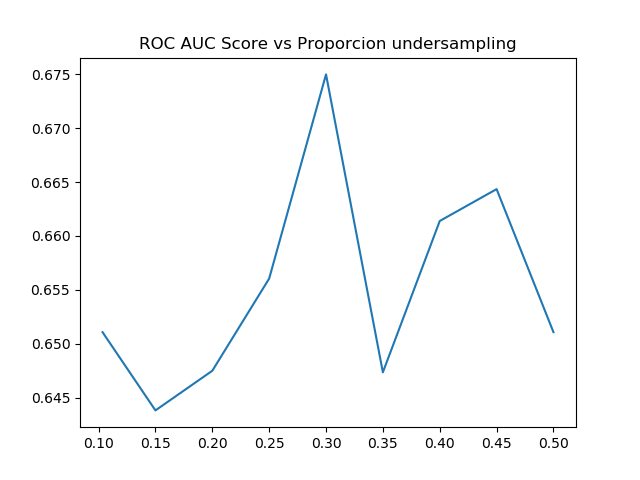

Text(0.5, 1.0, 'ROC AUC Score vs Proporcion undersampling')

In [92]:
plt.plot(props,rendims)
plt.title('ROC AUC Score vs Proporcion undersampling')

Recorda

De este caso de estudio, podemos ver que el rendimiento que tiene solo un subconjunto de variables es mejor para los 3 metodos en comparación a utilizar la totalidad de variables disponibles, igualmente vemos que el desempeño de los 3 metodos en el conjunto de test es muy parecido entre ellos, además de obtener resultados prometedores